In [1]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from src.vae_model import vae_model
from src.mapper_model import mapper_model
from src.util import (plot_mesh_permarray, load_all_data)

from pyeit import mesh
from keras import backend as K


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2024-12-04 14:22:16.287883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733322136.301553 1641258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733322136.305763 1641258 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 14:22:16.321024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1733322155.183124 1641258 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 16  
mesh_obj = mesh.create(n_el, h0=0.05)


In [3]:
voltage_dict, gamma_dict, anomaly_dict = load_all_data()

#z score normalisierung auf Voltage Daten 
#damit Mittelwert 0 und STD gleich 1 
# und das als Input für den Mapper verwenden
# statt dense conv1D
#andere loss funktion (MAE statt mse)

In [4]:
gamma = gamma_dict["gamma"]/15

voltage = voltage_dict["voltage"]

#Z score normalisation of voltage data
voltage_normalized = (voltage - np.mean(voltage, axis=0)) / np.std(voltage, axis=0)
#white noise 
#voltage = np.expand_dims(voltage_normalized, axis=2)

In [5]:
voltage.shape, voltage_normalized.shape

((20000, 192), (20000, 192))

In [6]:
#EIT = voltage4.reshape(-1, 32, 32, 1)
#perm_array = perm_array.reshape(-1, 2840, 1)
#Konvergenz erreichen, Variation in Daten, 2D und 3D Trajektorie (Klasse für den Drucker)

In [22]:
mapper = mapper_model()
mapper.summary()
optimizer = Adam(learning_rate=0.0001)
mapper.compile(optimizer=optimizer, loss="mae")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,704 (139.47 KB)

 Trainable params: 35,704 (139.47 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
vae = vae_model()  
vae.build(input_shape=(None, *gamma.shape[1:])) 
vae.load_weights("weights/vae.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [9]:
#gamma_train, gamma_test = train_test_split(gamma4, test_size=0.2, random_state=42)

z_mean, z_log_var, z = vae.encoder.predict(gamma)
#gamma_hat = vae.decoder.predict(z) * 150
#for idx in np.random.randint(0, high=gamma4.shape[0], size=5):
    #plot_mesh_permarray(mesh_obj, gamma4[idx,:,0], title = "True")
    #plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")

#z = np.expand_dims(z, axis=2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [21]:
(v_train, v_test, gamma_train, gamma_test, z_train, z_test) = train_test_split(voltage_normalized,gamma,z,test_size=0.1,shuffle=True,random_state=None)

white_noise = np.random.normal(0, 0.1, v_train.shape)
v_train = v_train + white_noise

v_train.shape, z.shape

((18000, 192), (20000, 8))

In [23]:
history_mapper = mapper.fit(
    v_train,  
    z_train,  
    epochs=200, 
    batch_size=32,
    validation_data=(v_test, z_test)  
)

Epoch 1/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8410 - val_loss: 0.8036
Epoch 2/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8100 - val_loss: 0.7885
Epoch 3/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7937 - val_loss: 0.7795
Epoch 4/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7840 - val_loss: 0.7732
Epoch 5/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7809 - val_loss: 0.7687
Epoch 6/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7760 - val_loss: 0.7662
Epoch 7/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7720 - val_loss: 0.7644
Epoch 8/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7697 - val_loss: 0.7623
Epoch 9/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7665 - val_loss: 0.7604
Epoch 10/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7645 - val_loss: 0.7591
Epoch 11/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7641 - val_loss: 0.7572
Epoch 12/200
563/563 ━━━━━━━━━━━━━━━━━━━━

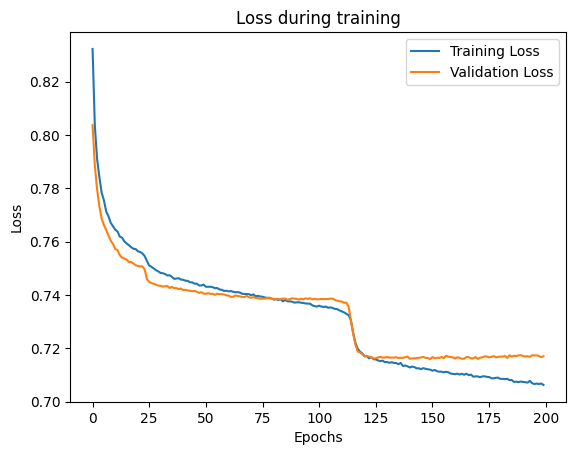

In [24]:
plt.plot(history_mapper.history['loss'], label='Training Loss')  # Training Loss
plt.plot(history_mapper.history['val_loss'], label='Validation Loss')  # Validation Loss
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#how to avoid overfittig in NN

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


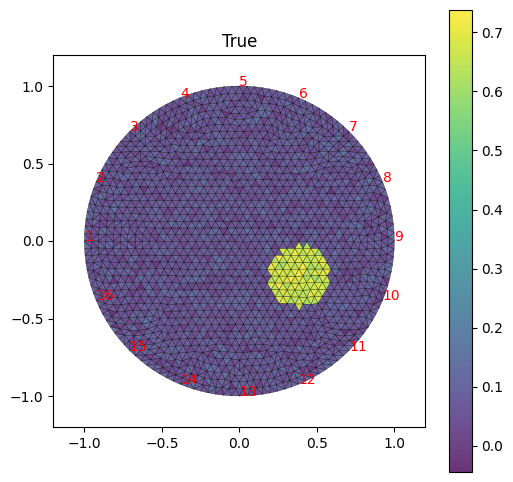

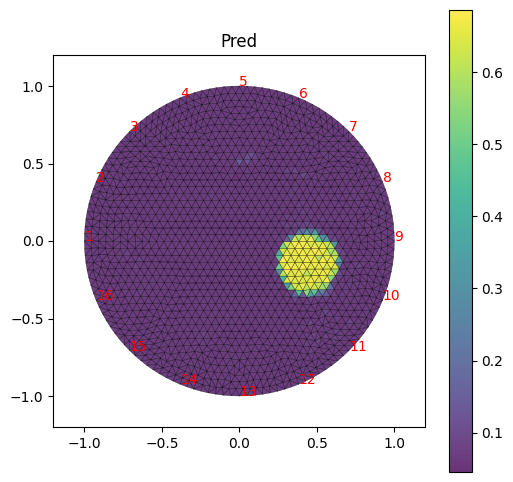

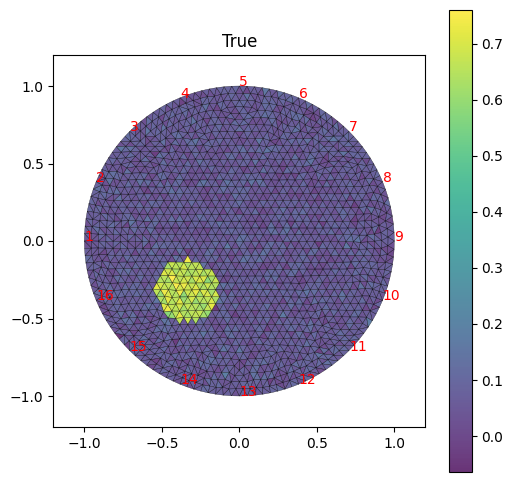

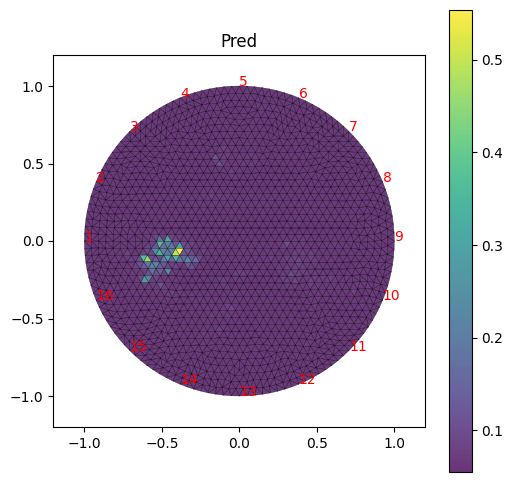

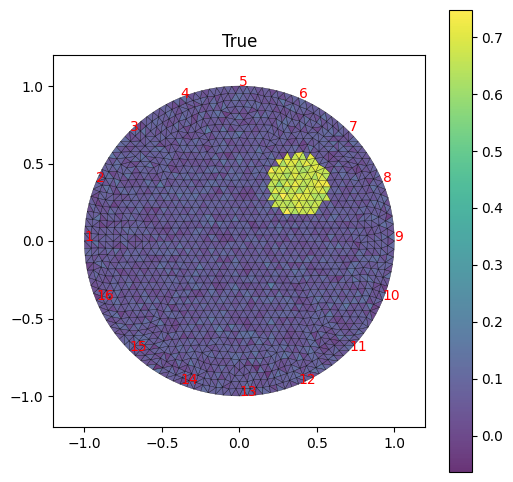

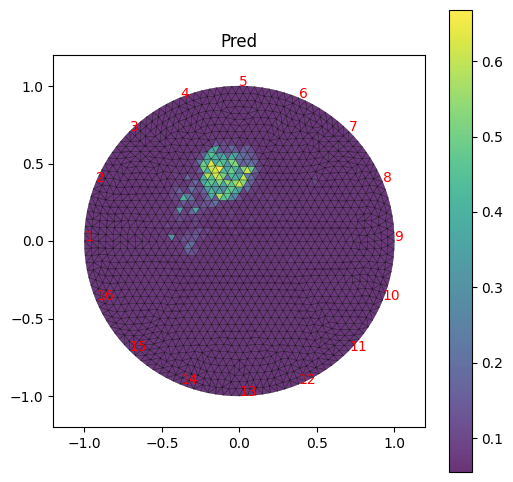

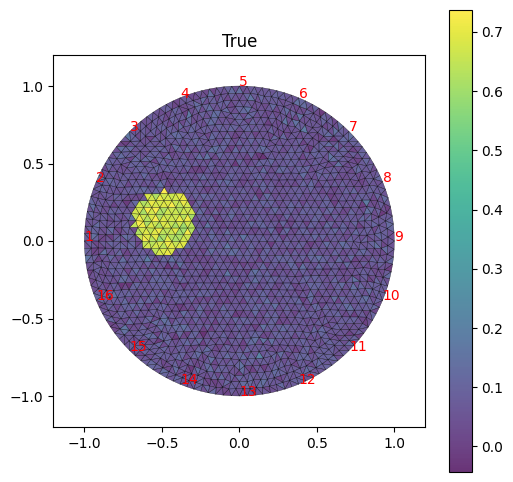

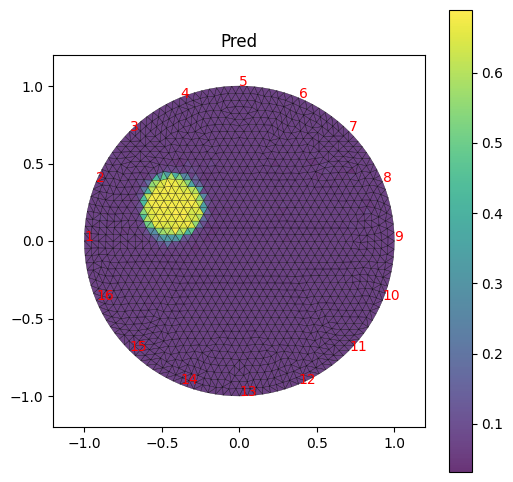

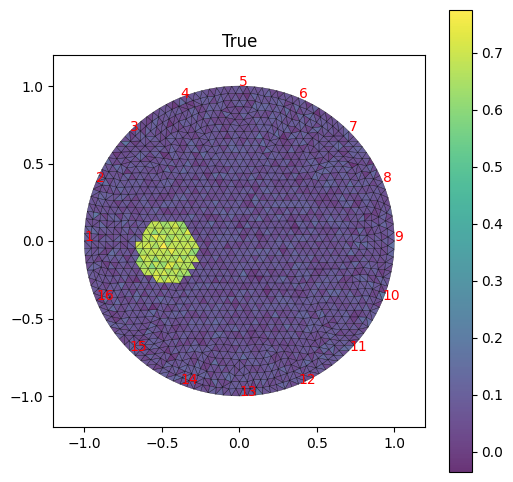

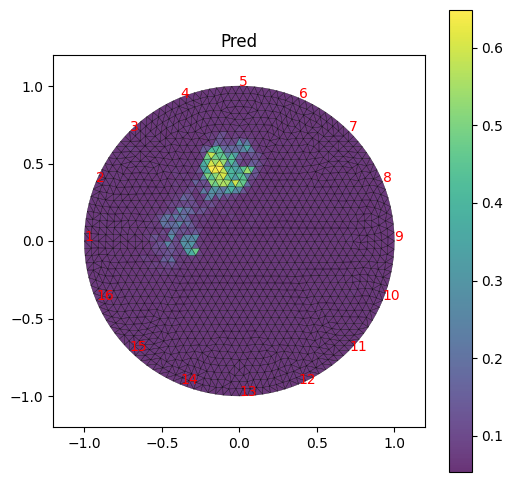

In [25]:
def reconstruct_from_voltage(voltage_input):
    z_hat = mapper.predict(voltage_input)
    gamma_hat = vae.decoder.predict(z_hat)
    return gamma_hat, z_hat

gamma_hat, z_hat = reconstruct_from_voltage(v_test)

for idx in np.random.randint(0, high=gamma_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, gamma_test[idx, :, 0], title="True")
    
    plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")
